In [1]:
options(warn=-1)
options(readr.num_columns = 0)

library(MLmetrics)
library(tidyverse)
library(kableExtra)
library(ggplot2)
library(caret)
library(class)

churn <- read_csv("../_build/data/churn_train.csv")
scaler <- preProcess(churn, method="range")
churnScaled <- predict(scaler, churn)
churnScaled$international_plan <- ifelse(churnScaled$international_plan=="yes", 1, 0)
churnScaled$voice_mail_plan <- ifelse(churnScaled$voice_mail_plan=="yes", 1, 0)
churnHoldout <- read_csv("../_build/data/churn_holdout.csv")
churnHoldoutScaled <- predict(scaler, churnHoldout)
churnHoldoutScaled$international_plan <- ifelse(churnHoldoutScaled$international_plan=="yes", 1, 0)
churnHoldoutScaled$voice_mail_plan <- ifelse(churnHoldoutScaled$voice_mail_plan=="yes", 1, 0)

cvConditions <- trainControl(method = "cv", number = 5)
set.seed(972945)
knnCV <- train(churn ~ ., 
                 data = churnScaled,
                 method = "knn", 
                 trControl = cvConditions, 
                 tuneGrid = expand.grid(k = c(1, 3, 5, 10, 20)))

finalModelPredictions <- predict(knnCV, churnHoldoutScaled)


Attaching package: 'MLmetrics'



The following object is masked from 'package:base':

    Recall



Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2


-- Attaching packages --------------------------------------- tidyverse 1.2.1 --


v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  


-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



Attaching package: 'kableExtra'



The following object is masked from 'package:dplyr':

    group_rows



Loading required package: lattice



Attaching package: 'caret'



The following object is masked from 'package:purrr':

    lift



The following objects are masked from 'package:MLmetrics':

    MAE, RMSE



# Performance Metrics

So far we have been evaluating our models via their accuracy, or the proportion of times when their predictions agreed with the true outcome. This is a simple measure to calculate, and in some circumstances is sufficient to evaluate the performance of a prediction model. However, there are many other performance metrics with different strengths and weaknesses that may be more useful depending on the context of the problem. In this section, we will cover some of the popular alternatives. The different metrics we describe in this chapter are organized by classification and regression problems.

## Classification

As a reminder, classification problems are those where the outcome variable is categorical. In this section, we focus on performance metrics for evaluating models with binary outcomes. 

### Confusion Matrices

From the accuracy score we calculated in Section [Holdout Sets](data_partition.html#holdout-sets), we know that our final model incorrectly predicted around 10% of the observations in the holdout set. But what kind of mistakes did it make? Did it label customers who *did* churn as non-churners? Or did it label customers who *did not* churn as churners? We can investigate this through a **confusion matrix**, or a table that breaks down the type of correct and incorrect predictions made by a model. We can create confusion matrices in R with the `ConfusionMatrix()` function from the `MLmetrics` package, which uses the following syntax:

```{admonition} Syntax
`MLmetrics::ConfusionMatrix(y_pred, y_true)`
+ *Required arguments*
  - `y_pred`: An atomic vector with the model predictions. 
  - `y_true`: An atomic vector with the true labels.
```

Applying this to our holdout set:

In [2]:
ConfusionMatrix(finalModelPredictions, churnHoldoutScaled$churn)

      y_pred
y_true  no yes
   no  715  25
   yes  61  49

What does this table tell us? The diagonal of the table (*i.e.*, 715 and 49) represents the observations that the model predicted correctly (715 + 49 = 764). Conversely, the off-diagonals (25 and 61) represent the observations that the model predicted incorrectly (25 + 61 = 86). If we divide the number of correct predictions (764) by the total number of observations in the holdout set (850), we get our accuracy score of 89.9%.

Now let's focus on each value in the confusion matrix:

+ The top-left cell indicates that the model correctly identified *715* of the non-churners. 
+ The top-right cell indicates that the model incorrectly flagged *25* non-churners as churners.
+ The bottom-left cell indicates that the model incorrectly flagged *61* churners as non-churners.
+ The bottom-right cell indicates that the model correctly identified *49* of the churners.

Why might this be more informative than simple accuracy? Although accuracy tells us the total number of mistakes our model made, it does not tell us which *type* of mistakes the model made. In this context, there are two possible mistakes: flagging someone who is not going to churn as a churner (known as a **false positive**), and flagging someone who is going to churn as a non-churner (known as a **false negative**).

Depending on the business context, these two types of mistakes may not be associated with identical costs. Assume that if our model predicts a customer is about to churn, we plan to offer that customer a \$100 rebate to convince them to stay with the service. In this case, it is likely much more costly to lose a customer than it is to provide the rebate to a customer that would not have churned. If we make a false positive error and incorrectly assume that someone is about to churn, we will unnecessarily lose \$100, as the customer would have stayed regardless of whether we gave them the rebate. Conversely, if we make a false negative error and incorrectly assume that someone is not about to churn, we will not offer them a rebate and permanently lose them as a customer. Therefore, a false negative is likely more costly than a false positive in this context. 

This is another example of the role managers play in the data science pipeline. A thorough understanding of the business context is required to evaluate the relative costs of these two types of errors. A highly accurate model may still be insufficient if it makes highly costly mistakes. It is therefore important that managers and data scientists collaborate to evaluate models *in the context of the business problem*. 

Up until now, we have been implicitly applying a cutoff of 50% to our model's predictions. Remember that the kNN algorithm predicts the *probability* that a given customer will churn (a value between 0% and 100%). When we applied the model to the holdout set using the `predict()` function (see Section [Holdout Sets](data_partition.html#holdout-sets)), this function automatically converted the model's predictions from a continuous probability to a discrete "churn" / "did not churn". By default `predict()` uses a cutoff of 50%. This means that if our model predicts the probability of churning as greater than 50%, the final prediction is considered "churn"; if the probability is less than 50%, the final prediction is considered "not churn". 

This cutoff of 50% seems like a natural threshold, but there is no reason we *must* choose 50%. As we noted above, the cost of a false positive and false negative error may be different. If the cost of a false positive is very high, we may only want to predict "churn" if we are very, very confident that the customer is about to churn. Therefore, we may want to increase the threshold above 50%. For example, we may only want to predict "churn" if the model's predicted probability is greater than 80%. Conversely, if the cost of a false negative is very high, we may want to decrease the threshold below 50%.

If we apply a different cutoff to our predictions, we will get a different confusion matrix for the same model. Let's start with a cutoff of 80%. First, we need to re-run the `predict()` function so that we get the raw probabilities, instead of just `"yes"` / `"no"`. We can do this by adding the optional parameter `type = "prob"` to the `predict()` function:

In [3]:
finalModelPredictionsProb <- predict(knnCV, churnHoldoutScaled, type = "prob")
head(finalModelPredictionsProb)

no,yes
0.6666667,0.3333333
1.0000000,0.0000000
1.0000000,0.0000000
1.0000000,0.0000000
1.0000000,0.0000000
1.0000000,0.0000000


This creates a data frame, where one column represents the model's predicted probability that the observation is a `"yes"`, and the other represents the predicted probability that the observations is a `"no"`. Note that these two columns always sum to 1. 

Now that we have the raw probabilities, we can apply our custom cutoff of 0.8. In the code below, we create a vector called `finalModelPredictions0.8`, where each element equals `"yes"` if the predicted probability of churning is greater than 80%, and `"no"` if the predicted probability is less than 80%.

In [4]:
finalModelPredictions0.8 <- ifelse(finalModelPredictionsProb$yes > 0.8, "yes", "no")
finalModelPredictions0.8[1:5]

[1] "no" "no" "no" "no" "no"

Now we can use `ConfusionMatrix()` to calculate the confusion matrix with our new cutoff of 80%:

In [5]:
ConfusionMatrix(finalModelPredictions0.8, churnHoldoutScaled$churn)

      y_pred
y_true  no yes
   no  739   1
   yes  94  16

As expected, this confusion matrix looks different than the one where we used a cutoff of 50%. Now, the model makes only one false positive error, but it makes many more false negative errors (94).

Let's repeat this process with a lower cutoff of 20%.

In [6]:
finalModelPredictions0.2 <- ifelse(finalModelPredictionsProb$yes > 0.2, "yes", "no")
ConfusionMatrix(finalModelPredictions0.2, churnHoldoutScaled$churn)

      y_pred
y_true  no yes
   no  623 117
   yes  25  85

Now that we apply a lower cutoff, the model makes less false negative errors (25), but more false positive errors (117).

As emphasized previously, it is the manager's job to determine which one of these cutoffs is appropriate. In general, if based on the business context a false negative error is more costly, one would want to apply a lower cutoff. If instead a false positive error is more costly, one would want to apply a higher cutoff.

### ROC Curves

To evaluate our model on the holdout set, we could continue looking at confusion matrices associated with different cutoffs. However, there are an infinite number of possible cutoffs to pick from between 0 and 1. Therefore, we need an evaluation method that is independent of arbitrary cutoff choices. One such method is the **ROC curve** (Receiver Operating Characteristic Curve), which plots the model's false positive and true positive rates across all possible cutoff values. 

Recall our three confusion matrices, which show the model's performance at different cutoffs (0.2, 0.5, and 0.8). For 0.2, the false positive rate (or the proportion of non-churners that are incorrectly flagged as churners) is 117 / (623 + 117) = 15.81%. The true positive rate (or the proportion of churners that are correctly flagged as churners) is 85 / (25 + 85) = 77.27%. For 0.5 the false positive and true positive rates are (3.38%, 44.55%) respectively, and for 0.8 these values are (0.14%, 14.55%). 

We also know that if we used a cutoff of one, all of the predictions would be "not churn", so the false positive and true positive rates would be (0%, 0%). Similarly, if we used a cutoff of zero, all of the predictions would be "churn", so the false positive and true positive rates would be (100%, 100%).

Let's plot these five points, with the false positive rate on the x-axis and the true positive rate on the y-axis:

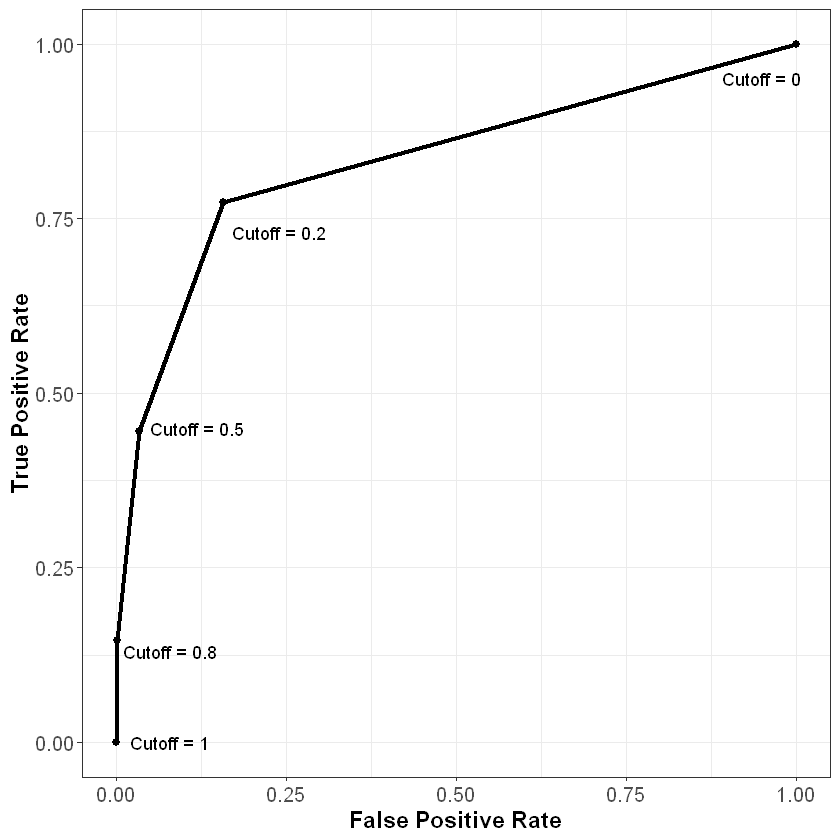

In [7]:
points <- data.frame(fp=c(0, 0.1581081, 0.03378378, 0.001351351, 1), tp=c(0, 0.7727273, 0.4454545, 0.1454545, 1))
ggplot(points, aes(x=fp, y=tp)) + geom_point(size=2)  + geom_line(size=1.25) +
  theme_bw() +
  xlim(0, 1) + ylim(0, 1) +
  xlab("False Positive Rate") + ylab("True Positive Rate") + 
  theme(axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold")) + 
  annotate("text", x = 0.08, y = 0, label = "Cutoff = 1") + 
  annotate("text", x = 0.08, y = 0.13, label = "Cutoff = 0.8") +
  annotate("text", x = 0.12, y = 0.45, label = "Cutoff = 0.5") +
  annotate("text", x = 0.24, y = 0.73, label = "Cutoff = 0.2") +
  annotate("text", x = 0.95, y = 0.95, label = "Cutoff = 0")

As we can see from this curve, we face a tradeoff when it comes to the cutoff value we choose. As we decrease the value of the cutoff, our true positive rate increases, which means we correctly flag more people who will end up churning. However, our false positive rate also increases, meaning we incorrectly flag more people who will *not* end up churning. As always, how one chooses to balance this tradeoff (*i.e.*, how to pick the correct cutoff) depends on the business context of the problem.

To understand this curve even further, consider what it would look like if we just randomly guessed the probability of churning for each observation. Because we are guessing randomly, at any given cutoff the probability of a false positive would be the same as the probability of a true positive. Therefore, a very poor model that randomly guessed at the outcome would be plotted on the 45 degree line, where the false positive and true positive rates are the same. This is shown below in the red dotted line.

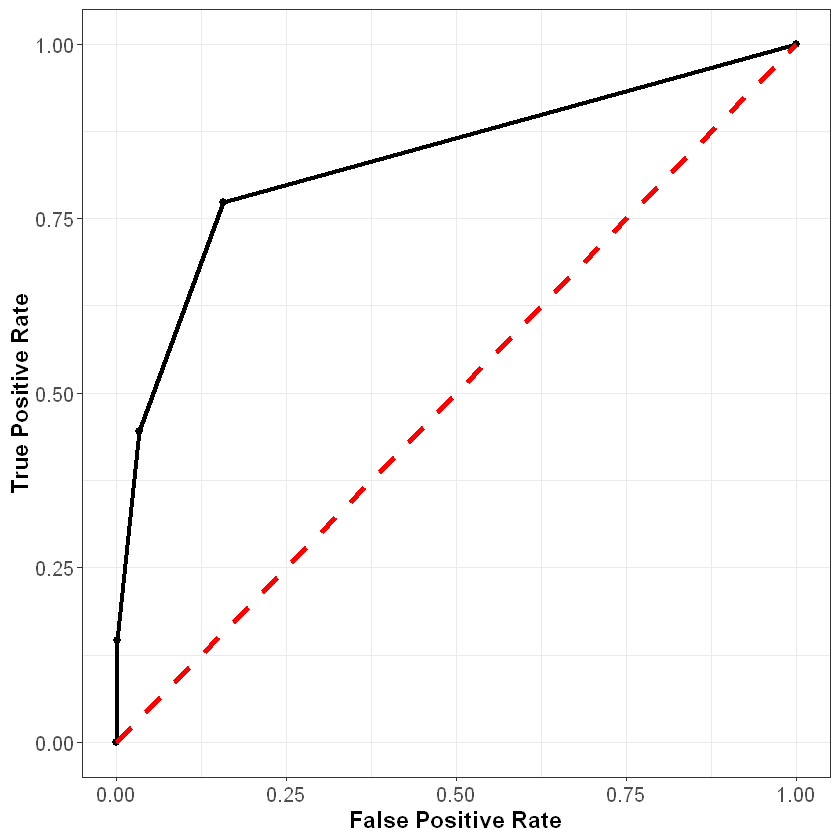

In [8]:
points <- data.frame(fp=c(0, 0.1581081, 0.03378378, 0.001351351, 1), tp=c(0, 0.7727273, 0.4454545, 0.1454545, 1))
badPoints <- data.frame(fp=c(0,1), tp=c(0,1))
ggplot(points, aes(x=fp, y=tp)) + geom_point(size=2)  + geom_line(size=1.25) +
  theme_bw() +
  xlim(0, 1) + ylim(0, 1) +
  xlab("False Positive Rate") + ylab("True Positive Rate") + 
  theme(axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold")) + 
  geom_line(data=badPoints, aes(x=fp, y=tp), linetype = "dashed", color="red", size=1.5) 

Finally, consider what the curve would look like with a perfect model. For observations that did churn, this model would predict the probability of churning to be 100%, and for observations that did not churn, this model would predict the probability of churning to be 0%. At a threshold of one the false positive and true positive rates would still be (0%, 0%), and at a threshold of zero these rates would still be (100%, 100%). However, for any other threshold, the false positive and true positive rates would be (0%, 100%). This curve is plotted below in the blue dashed line.

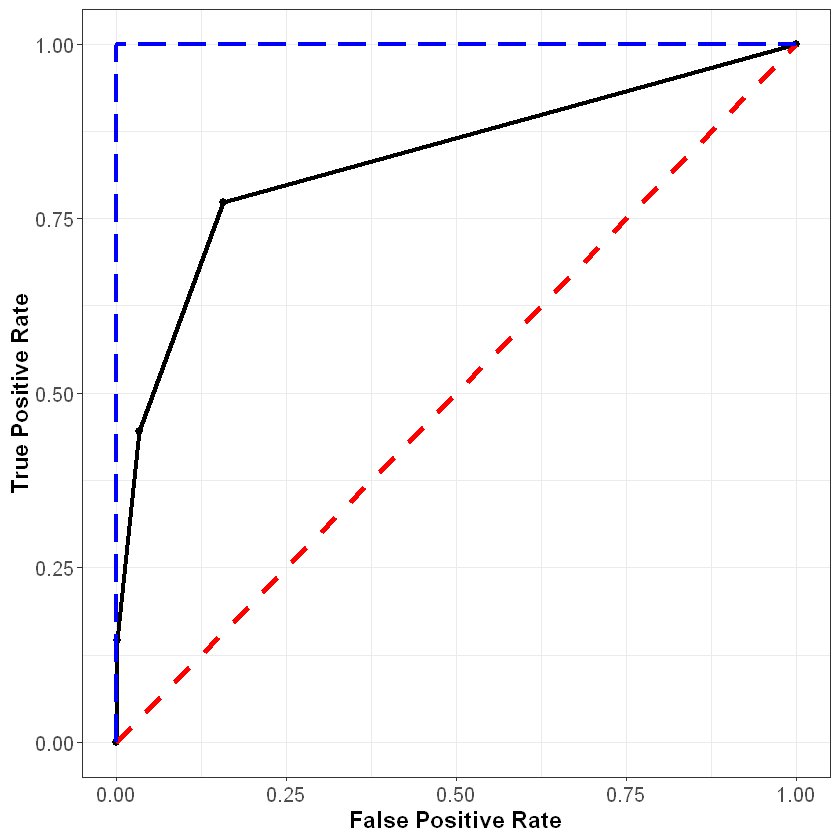

In [9]:
points <- data.frame(fp=c(0, 0.1581081, 0.03378378, 0.001351351, 1), tp=c(0, 0.7727273, 0.4454545, 0.1454545, 1))
badPoints <- data.frame(fp=c(0,1), tp=c(0,1))
perfectPoints <- data.frame(fp=c(0,0,1), tp=c(0,1,1))
ggplot(points, aes(x=fp, y=tp)) + geom_point(size=2)  + geom_line(, size=1.25) +
  theme_bw() +
  xlim(0, 1) + ylim(0, 1) +
  xlab("False Positive Rate") + ylab("True Positive Rate") + 
  theme(axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold")) + 
  geom_line(data=badPoints, aes(x=fp, y=tp), linetype = "dashed", color="red", size=1.5) +
  geom_line(data=perfectPoints, aes(x=fp, y=tp), linetype = "longdash", color="blue", size=1.25)

In general, the better our model, the closer the ROC curve will be to the blue line, and the further away it will be from the red line. 

Access the web application below to further explore the relationship between confusion matrices, ROC curves, and the model threshold.

<a href="https://hbs-data-science.shinyapps.io/churn_roc/" class="btn btn-primary" style="color:white;" target="_blank">Launch Application!</a>

We can plot the ROC curve for our model in R using the `prediction()` and `performance()` functions from the `ROCR` package. These functions use the following syntax:

```{admonition} Syntax
`ROCR::prediction(predictions, labels)`
+ *Required arguments*
  - `y_pred`: An atomic vector with the model predictions. 
  - `y_true`: An atomic vector with the true labels.
```

```{admonition} Syntax
`ROCR::performance(predictionObj, measure1, measure2, ...)`
+ *Required arguments*
  - `predictionObj`: An object created using the `prediction()` function. 
  - `measure1`: The desired model performance measure. See the "Details" section [here](https://www.rdocumentation.org/packages/ROCR/versions/1.0-1/topics/performance) for a full list. For our purposes, we will use "tpr" for the true positive rate and "fpr" for the false positive rate.
+ *Optional arguments*
  - `measure2, ...`: Any additional model performance measures. 
```
  
Below we apply these functions to create an object `roc`, which can be passed to the `plot()` function to plot the ROC curve:

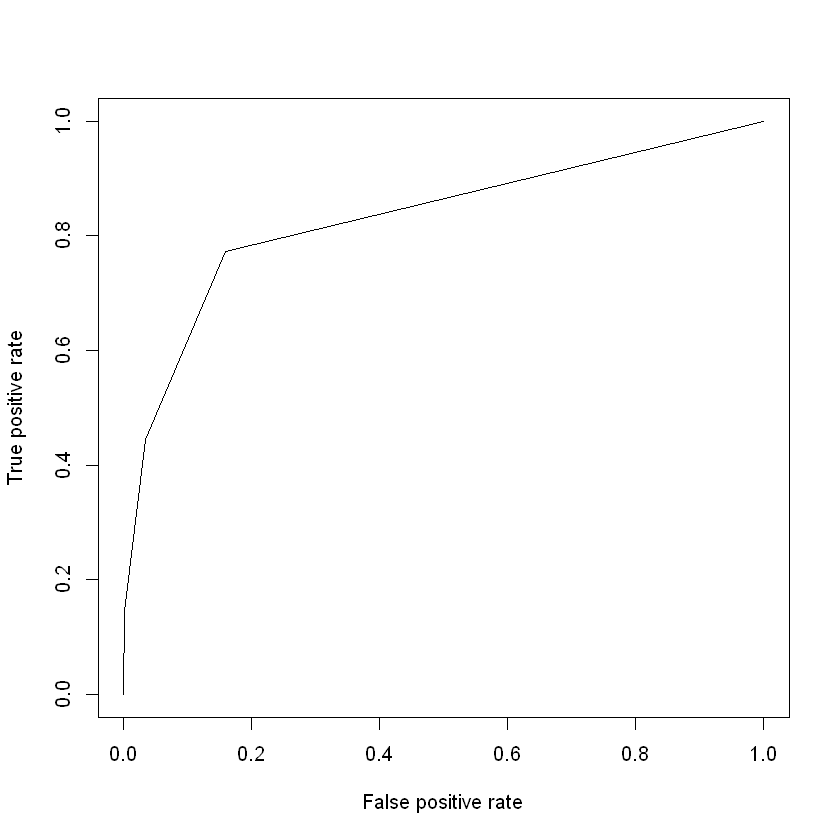

In [10]:
library(ROCR)

rocPrediction <- prediction(finalModelPredictionsProb$yes, churnHoldoutScaled$churn)
roc <- performance(rocPrediction, "tpr", "fpr")

plot(roc)

We can summarize this plot numerically through a measure known as **area under the ROC curve (AUC)**, which (as the name implies) measures the area underneath our plotted ROC curve. If our curve fell on the red dotted line (representing the worst possible model), the area under the curve would be 0.5. Conversely, if our curve fell on the blue dotted line (representing the best possible model), the area under the curve would be 1. Therefore, the closer our AUC is to 1, the better our model, and the closer it is to 0.5, the worse our model. Note that because it is based on the ROC curve, this metric is independent of any particular cutoff value, unlike accuracy and confusion matrices. 

We can calculate the AUC of our model in R using the `AUC()` function the `MLmetrics` package, which uses the following syntax:

```{admonition} Syntax
`MLmetrics::AUC(y_pred, y_true)`
+ *Required arguments*
  - `y_pred`: An atomic vector with the model's predicted probabilities. 
  - `y_true`: An atomic vector with the true labels, represented numerically as 0 / 1. Note that this is different from some of the other functions from `MLmetrics`, where the labels can be in their original form (*i.e.*, "churn" / "not churn"). 
```

Below we apply this function to our model. Note that `churnHoldoutScaled$churn` labels the observations as "no" or "yes", but the `AUC()` function expects them to be labeled as 0 or 1 (respectively). Therefore, we first need to re-code the true values from "no" / "yes" to 0 / 1.

In [11]:
# Convert labels to binary (0 / 1)
trueLabelsBinary <- ifelse(churnHoldoutScaled$churn=="yes", 1, 0)

# Calculate AUC
AUC(finalModelPredictionsProb$yes, trueLabelsBinary)

[1] 0.8316278

### Log Loss

Another problem with simple accuracy is that it does not take into account the strength of each prediction. Imagine two competing models that both correctly predict a given customer will churn. Model 1 outputs a predicted probability of 0.51, while Model 2 outputs a predicted probability of 0.99. If we were scoring based on simple accuracy, these models would be considered equivalent (at a cutoff of 0.5) - both correctly predicted that the customer would churn. The problem with this scoring method is that it does not reward Model 2 for having a predicted probability much closer to 1.

One solution to this issue is to score classification models via **log loss**, which is defined as:

$$Log\ Loss = -\frac{1}{n}\sum^{n}_{i=1}[y_ilog(\hat{p_i}) + (1 - y_i)log(1 - \hat{p_i})]$$

where 

+ $n$ is the number of observations in the data set
+ $y_i$ is the observed realization of observation $i$; it equals 1 if the observation churned and 0 if not
+ $\hat{p_i}$ is the predicted probability that observation $i$ churned according to the model

To help understand log loss, think through the following scenarios:

+ **Great predictions**
  + **$y_i$ = 1 & $\hat{p_i}$ = 0.99:** the observation actually churned, and the model estimated the probability of a churn to be 99%. 

  $$logloss_i = 1log(0.99) + (1-1)log(1-0.99) = log(0.99) \approx \mathbf{-0.004}$$

  + **$y_i$ = 0 & $\hat{p_i}$ = 0.01:** the observation did not churn, and the model estimated the probability of a churn to be 1%. 

  $$logloss_i = 1log(0.99) + (1-1)log(1-0.99) = log(0.99) \approx \mathbf{-0.004}$$  


+ **Terrible predictions**
  + **$y_i$ = 0 & $\hat{p_i}$ = 0.99:** the observation did not churn, but the model estimated the probability of a churn to be 99%. 

  $$logloss_i = 0log(0.99) + (1-0)log(1-0.99) = log(0.01) = \mathbf{-2}$$

  + **$y_i$ = 1 & $\hat{p_i}$ = 0.01:** the observation actually churned, but the model estimated the probability of a churn to be only 1%.

  $$logloss_i = 1log(0.01) + (1-1)log(1-0.01) = log(0.01) = \mathbf{-2}$$


From these examples, it is clear that the absolute value of the log loss is small when the model is close to the truth and large when the model is far off. Now consider the following:

+ **Good (not great) predictions**
    + **$y_i$ = 1 & $\hat{p_i}$ = 0.66:** the observation actually churned, and the model estimated the probability of a churn to be 66%. 

    $$logloss_i = 1log(0.66) + (1-1)log(1-0.66) = log(0.66) \approx \mathbf{-0.1805}$$

    + **$y_i$ = 0 & $\hat{p_i}$ = 0.33:** the observation did not churn, and the model estimated the probability of a churn to be 33%. 

    $$logloss_i = 0log(0.33) + (1-0)log(1-0.33) = log(0.66) \approx \mathbf{-0.1805}$$


+ **Bad (not terrible) predictions**
  + **$y_i$ = 0 & $\hat{p_i}$ = 0.66:** the observation did not churn, but the model estimated the probability of a churn to be 66%. 

  $$logloss_i = 0log(0.66) + (1-0)log(1-0.66) = log(0.33) \approx \mathbf{-0.4815}$$

  + **$y_i$ = 1 & $\hat{p_i}$ = 0.33:** the observation actually churned, but the model estimated the probability of a churn to be only 33%.

  $$logloss_i = 1log(0.33) + (1-1)log(1-0.33) = log(0.33) \approx \mathbf{-0.4815}$$


Notice that as our predictions go from terrible to bad to good to great, the log loss decreases in absolute value (*i.e.*, it gets closer to zero). A perfect classifier would have a log loss of precisely zero. Less ideal classifiers have progressively larger values of log loss.

We can calculate log loss in R using the `LogLoss()` function from the `MLmetrics` package, which uses the following syntax:

```{admonition} Syntax
`MLmetrics::LogLoss(y_pred, y_true)`
+ *Required arguments*
  - `y_pred`: An atomic vector with the model's predicted probabilities. 
  - `y_true`: An atomic vector with the true labels, represented numerically as 0 / 1. Note that this is different from some of the other functions from `MLmetrics`, where the labels can be in their original form (*i.e.*, "churn" / "not churn").
```

Like `AUC()`, to use this function we first need to re-code the true values from "no" / "yes" to 0 / 1.

In [12]:
# Convert labels to binary (0 / 1)
trueLabelsBinary <- ifelse(churnHoldoutScaled$churn=="yes", 1, 0)

# Calculate log loss
LogLoss(finalModelPredictionsProb$yes, trueLabelsBinary)

[1] 1.193657

## Regression

[In Progress]

### MAE

[In Progress]

### MAPE

[In Progress]